
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## Obtain Anual Weather Types (AWT) for future climate conditions

Generates future AWT time series and correspondent PCs

inputs required: 
* Future probabilities of AWTs 
* Synthetic tri-variate annual PCs (APC1,APC2, and APC3)


in this notebook:
  * Obtain historical AWT transistion probability matrix
  * Modify transistion probability matrix according to future probabilities
  * Synthetic generation of AWT based on a first-order markov chain (i.e. generation of AWTs using the modified transistion probability matrix)
  * Synthetic generation of tri-variate annual PCs (APC1,APC2, and APC3)



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op
import pickle
from datetime import datetime

# pip
import xarray as xr
import numpy as np
np.set_printoptions(precision=4, suppress=True)

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..', '..'))

# teslakit 
from teslakit.database import Database
from teslakit.kma import ClusterProbabilities, ChangeProbabilities

from teslakit.plotting.wts import Plot_Compare_Transitions

from teslakit.io.aux_nc import StoreBugXdset
from teslakit.util.time_operations import xds_reindex_daily, xds_reindex_monthly



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database
p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('KWAJALEIN_emulator')

# climate change - S5
db_S5 = Database(p_data)
db_S5.SetSite('KWAJALEIN_CC_S5')


In [3]:
# --------------------------------------
# load data and set parameters
SST_AWTs = db.Load_SST_KMA()
bmus_hist = SST_AWTs.bmus.values[:] + 1 # for plotting comparison

# Load SST PCs123 random generated with Copulas
PCs_fit, PCs_rnd = db.Load_SST_PCs_fit_rnd()

# SST Predictor PCA parameters
pca_year_ini = 1880
pca_year_end = 2019
pca_month_ini = 6
pca_month_end = 5
num_clusters = 6

# New AWT probabilities (expected probabilities under rcp8.5)
WT_probs_new = [17, 10, 16, 9, 23, 25] # must sum 100%
WT_probs_new = [x/100 for x in WT_probs_new]

# Simulation
num_sims = 100
y1_sim = 2000
y2_sim = 3000


## Present & Future AWT probabilities

In [4]:
# Get probability of each AWT (just for info)
set_values = np.arange(num_clusters) + 1
WT_probs = ClusterProbabilities(bmus_hist, set_values)

print('current AWT probabilities')
print(WT_probs)
print(np.sum(WT_probs)) 

print('future AWT probabilities')
print(WT_probs_new)
print(np.sum(WT_probs_new))
print()


# Get current transition probability matrix
set_values = np.arange(num_clusters) + 1
WT_trans_matrix = ChangeProbabilities(bmus_hist, set_values)[1]  # matriz probs cambio (markov 1)


# Obtain stable AWTs probabilities from current transition probability matrix
A = np.append(np.transpose(WT_trans_matrix)-np.identity(num_clusters), np.ones((1,num_clusters)), axis=0)
b = np.append(np.zeros((num_clusters,1)),[[1]])
WT_probs_stable = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

print('stable AWT probabilities from current transition probability matrix (markov=1)')
print(WT_probs_stable)
print(np.sum(WT_probs_stable))


current AWT probabilities
[0.1286 0.2143 0.0929 0.1571 0.1786 0.2286]
1.0
future AWT probabilities
[0.17, 0.1, 0.16, 0.09, 0.23, 0.25]
1.0

stable AWT probabilities from current transition probability matrix (markov=1)
[0.1278 0.2147 0.0929 0.1535 0.1792 0.232 ]
1.0


## Modify transition probability matrix according to future AWT probs


In [5]:

# Obtain alfa and beta (parameters that modify each WT transition prob). Solves a linear matrix equation

alfa_p = np.identity(num_clusters)
beta_p = WT_trans_matrix

alfa_q = np.zeros(np.shape(WT_trans_matrix))*np.nan
for i in range(num_clusters):    
    for j in range(num_clusters):
        alfa_q[i,j] = beta_p[j][i]*WT_probs_new[j]

        
beta_q = np.zeros(np.shape(WT_trans_matrix))
for i in range(num_clusters):
    beta_q[i,i] = np.sum(alfa_q, axis=1)[i]

    
A = np.concatenate((alfa_p, beta_p), axis=1)
B = np.concatenate((alfa_q, beta_q), axis=1)
a = np.concatenate((A,B), axis=0)


b = np.zeros((1,num_clusters*2))
b = b[0] 
for i in range(num_clusters):
    b[num_clusters+i] =  WT_probs_new[i]- beta_q[i][i]


# solve 
alfa_beta = np.linalg.solve(a, b)
alfa = alfa_beta[:num_clusters]
beta = alfa_beta[num_clusters:]

print(alfa)
print()
print(beta)


[-0.1566 -0.6957  0.0563 -0.6686 -0.0903 -0.0418]

[ 1.4494 -0.3033  1.1474 -0.5041  0.7998  0.    ]


In [6]:
# modify transition probability matrix with obtained alfa & beta

WT_trans_matrix_new = np.zeros(np.shape(WT_trans_matrix))*np.nan

for i in range(num_clusters):
    for j in range(num_clusters):
        WT_trans_matrix_new[i][j] = WT_trans_matrix[i][j] * (1 + alfa[i] + beta[j])

print('transition probability matrix from historical bmus')
print(WT_trans_matrix)
print()
print('transition probability matrix modified acording to expected probs rcp8.5')
print(WT_trans_matrix_new)
print()


transition probability matrix from historical bmus
[[0.0556 0.2778 0.1111 0.1111 0.1111 0.3333]
 [0.2333 0.1667 0.1    0.     0.3667 0.1333]
 [0.     0.1667 0.0833 0.3333 0.0833 0.3333]
 [0.3182 0.3636 0.1818 0.     0.1364 0.    ]
 [0.     0.2    0.08   0.2    0.2    0.32  ]
 [0.0938 0.1562 0.0312 0.3125 0.0938 0.3125]]

transition probability matrix modified acording to expected probs rcp8.5
[[ 0.1274  0.15    0.2212  0.0377  0.1826  0.2811]
 [ 0.4092  0.0002  0.1452 -0.      0.4049  0.0406]
 [ 0.      0.1255  0.1836  0.1841  0.1547  0.3521]
 [ 0.5666  0.0102  0.2689 -0.      0.1543  0.    ]
 [ 0.      0.1213  0.1646  0.0811  0.3419  0.2911]
 [ 0.2257  0.1023  0.0658  0.1419  0.1648  0.2994]]



In [7]:
#---------------------
# TODO: esto se borra

# Check that the AWTs probabilites obtained from the modified transition prob matrix, are as expected\n",
A = np.append(np.transpose(WT_trans_matrix_new)-np.identity(num_clusters), np.ones((1,num_clusters)), axis=0)
b = np.append(np.zeros((num_clusters,1)),[[1]])
WT_probs_new_stable = np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))
    
print('-------')
print(WT_probs_new)
print(WT_probs_new_stable)
print()


-------
[0.17, 0.1, 0.16, 0.09, 0.23, 0.25]
[0.17 0.1  0.16 0.09 0.23 0.25]



## Generate future bmus (markov = 1)


In [8]:
time_sim = [datetime(y, pca_month_ini,1) for y in range(y1_sim-1, y2_sim+1)]


# bmus generation
bmus_sim = np.zeros((len(time_sim), num_sims), dtype=int) * np.nan

c = 0 # contador
for s in range(num_sims):
    ind_row = bmus_hist[:1] -1  # first bmus state. from 0 to 5

    while c < len(time_sim):
        trans_prob_wt = np.cumsum(WT_trans_matrix_new[ind_row, :])
        nrnd = np.random.rand()
        ind_col = np.where(trans_prob_wt > nrnd)[0][0]

        bmus_sim[c, s] = ind_col + 1

        ind_row = ind_col
        c += 1
    c = 0
  
    
# obtain AWTs probabilities of synthetic bmus for each sim
WT_probs_sim = np.zeros((num_sims, num_clusters)) * np.nan

for s in range(num_sims):
    WT_probs_sim[s,:] = ClusterProbabilities(bmus_sim[:,s], set_values)


# Obtain mean values of AWT probs from all simulations
WT_probs_sim_mean = np.mean(WT_probs_sim, axis=0)
print('WT probs (mean) for synthetic simulations')
print(WT_probs_sim_mean)
print()
print('future AWT probabilities')
print(WT_probs_new)


WT probs (mean) for synthetic simulations
[0.1703 0.0991 0.1593 0.0889 0.2302 0.2522]

future AWT probabilities
[0.17, 0.1, 0.16, 0.09, 0.23, 0.25]


In [9]:
# Save
SST_AWTs_sim = xr.Dataset(
    {
        'evbmus_sims' : (('time','n_sim'), bmus_sim.astype(int)),
    },
    coords = {
        'time' : time_sim,
        'n_sim' : range(num_sims),
    },
)

db_S5.Save_SST_AWT_sim(SST_AWTs_sim)


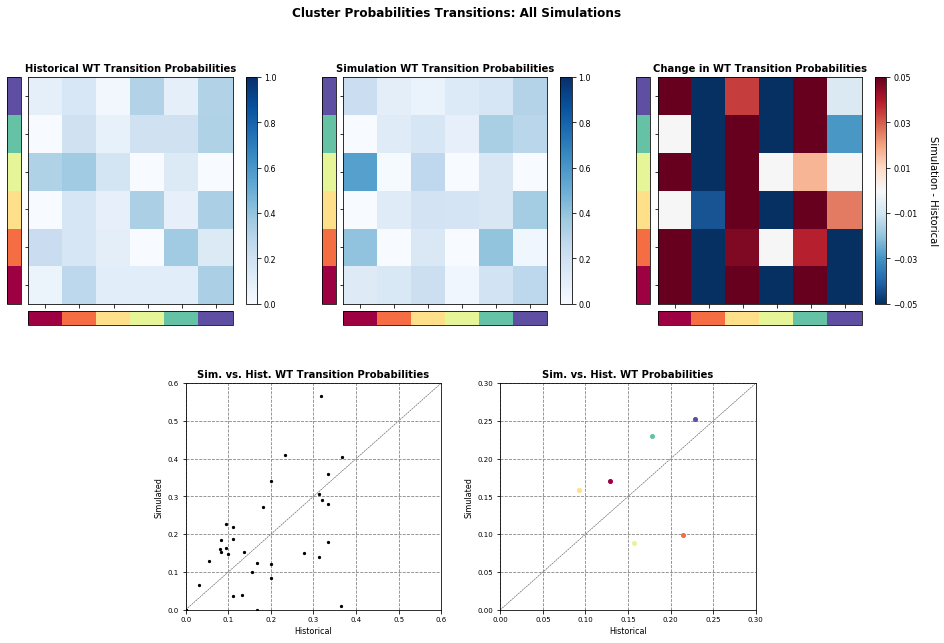

In [10]:
# Compare historical and simulation cluster probabilities transitions

Plot_Compare_Transitions(num_clusters, bmus_hist, SST_AWTs_sim.evbmus_sims, sttl='Cluster Probabilities Transitions: All Simulations', show=True);
 

In [11]:
# --------------------------------------
# PCs generation

vari = SST_AWTs.variance.values[:]

# solve each ALR simulation
l_PCs_sim = []
for s in SST_AWTs_sim.n_sim:

    evbmus_sim = SST_AWTs_sim.sel(n_sim=s).evbmus_sims.values[:]

    # generate random PCs
    pcs123_sim = np.empty((len(evbmus_sim),3)) * np.nan
    for c, m in enumerate(evbmus_sim):
        options = PCs_rnd['{0}'.format(int(m))]
        r = np.random.randint(options.shape[0])
        pcs123_sim[c,:] = options[r,:]
        
    # denormalize simulated PCs
    PC1_sim = np.multiply(pcs123_sim[:,0], np.sqrt(vari[0]))
    PC2_sim = np.multiply(pcs123_sim[:,1], np.sqrt(vari[1]))
    PC3_sim = np.multiply(pcs123_sim[:,2], np.sqrt(vari[2]))

    # append simulated PCs
    l_PCs_sim.append(
        xr.Dataset(
            {
                'PC1'  : (('time',), PC1_sim),
                'PC2'  : (('time',), PC2_sim),
                'PC3'  : (('time',), PC3_sim),
                'evbmus_sim' : (('time',), evbmus_sim),
            },
            {'time' : time_sim}
        )
    )

# concatenate simulations
SST_PCs_sim = xr.concat(l_PCs_sim, 'n_sim')
print(SST_PCs_sim)

# store simulated PCs
db_S5.Save_SST_PCs_sim(SST_PCs_sim)


<xarray.Dataset>
Dimensions:     (n_sim: 100, time: 1002)
Coordinates:
  * time        (time) object 1999-06-01 2000-06-01 ... 2999-06-01 3000-06-01
Dimensions without coordinates: n_sim
Data variables:
    PC1         (n_sim, time) float64 25.13 11.53 9.942 ... -9.877 -8.922 -15.93
    PC2         (n_sim, time) float64 0.9948 22.11 -1.072 ... 7.758 17.94 -9.461
    PC3         (n_sim, time) float64 5.232 -6.449 -13.76 ... -2.184 -8.258
    evbmus_sim  (n_sim, time) int64 1 3 4 1 6 5 6 2 5 5 ... 4 1 6 4 1 3 3 4 3 6
